In [335]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import curve_fit
import uncertainties as unc
from sympy.abc import *

In [349]:
def get_measurementsData(filenames, measurement_starting_indexes, measurement_last_indexes):
    t = []
    x = []
    v = []
    a = []
    for i in range(len(filenames)):
        filename = filenames[i]
        first_index = measurement_starting_indexes[i]
        last_index = measurement_last_indexes[i]

        df = pd.read_csv(filename, header=None)
        t.append(df.iloc[first_index:last_index, 3].to_numpy().astype(float))
        x.append(df.iloc[first_index:last_index, 5].to_numpy().astype(float))
        v.append(df.iloc[first_index:last_index, 7].to_numpy().astype(float))
        a.append(df.iloc[first_index:last_index, 9].to_numpy().astype(float))
    return t, x, v, a


measurement_starting_indexes = [130, 100, 60, 120, 70]
measurement_last_indexes = [270, 240, 220, 270, 220]
number_of_intervals_per_measurement=3
filenames = [
    './final_data/run1_height_4.csv', 
    './final_data/run2_height_4.csv',
    './final_data/run3_height_4.csv',
    './final_data/run4_height_4.csv',
    './final_data/run5_height_4.csv']

t, x, v, a = get_measurementsData(filenames, measurement_starting_indexes, measurement_last_indexes)
# merge all measurements into single np arrays
#t = np.concatenate((t))
#x = np.concatenate((x))
#v = np.concatenate((v))
#a = np.concatenate((a))
a_means = []
for i in range(len(t)):
    a_means.append(np.mean(a[i])) # we want a to be constant always, therefore we take the mean from the whole population

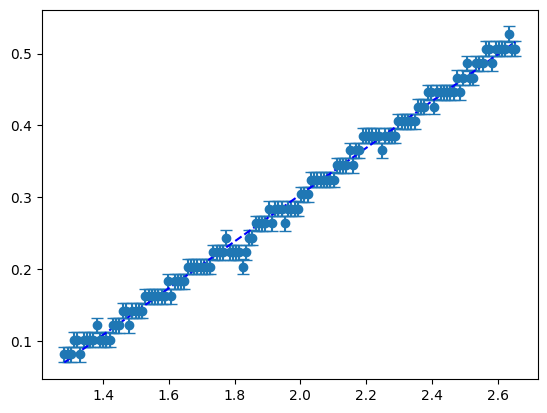

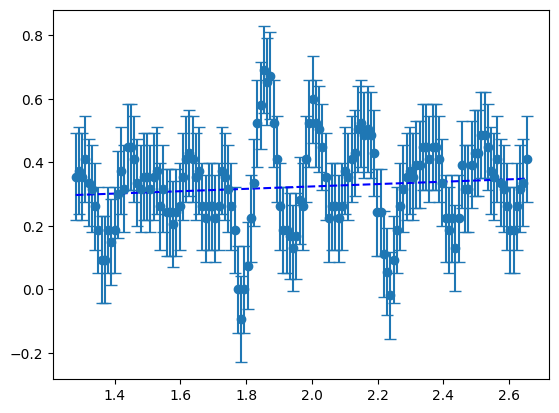

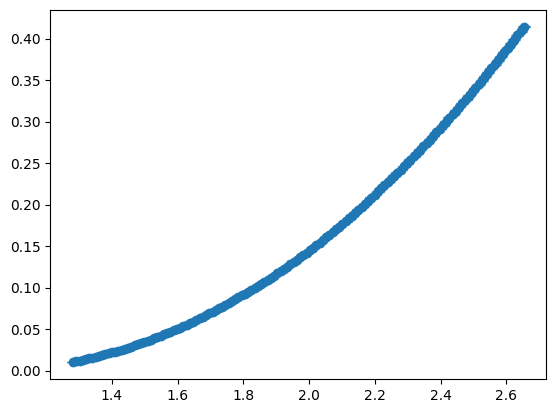

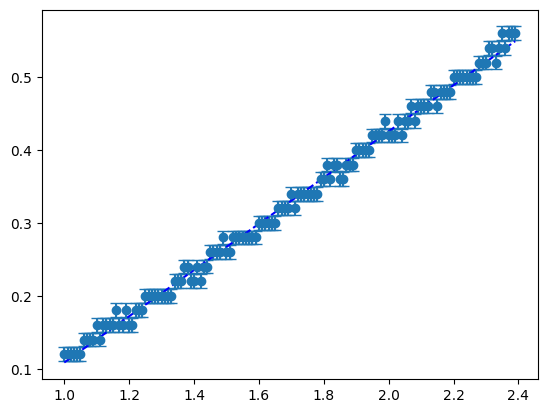

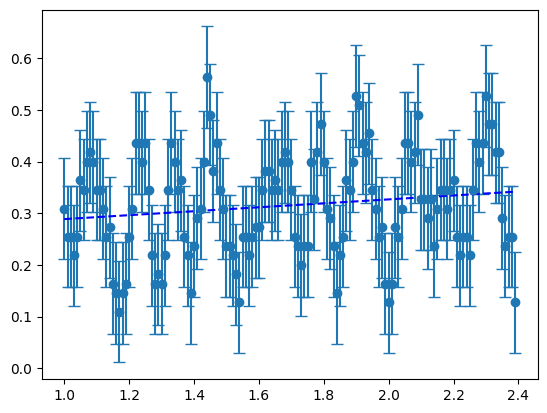

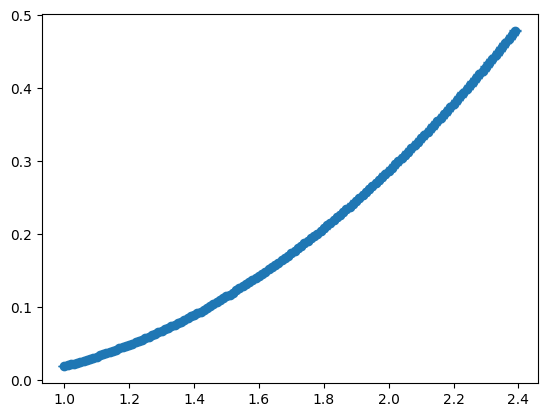

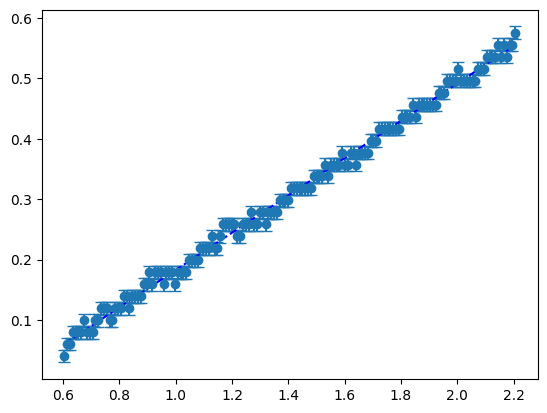

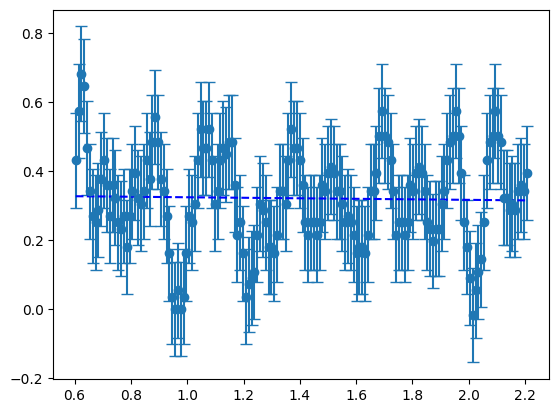

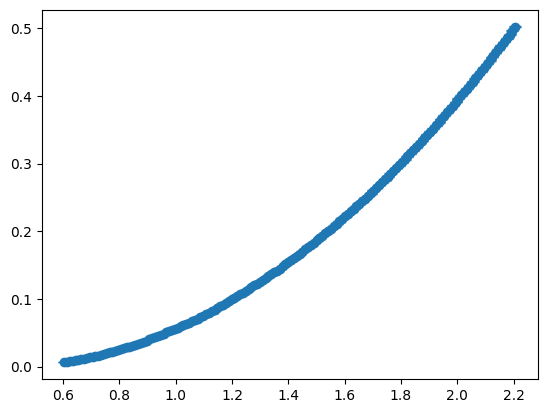

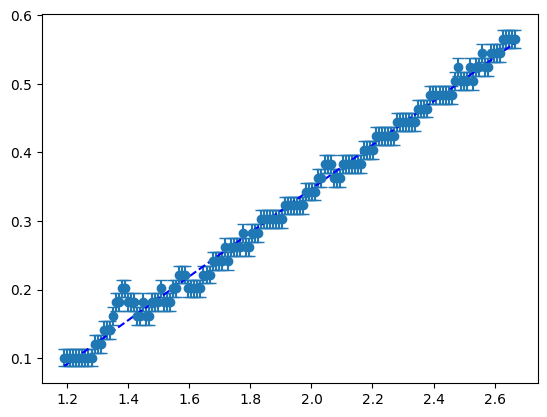

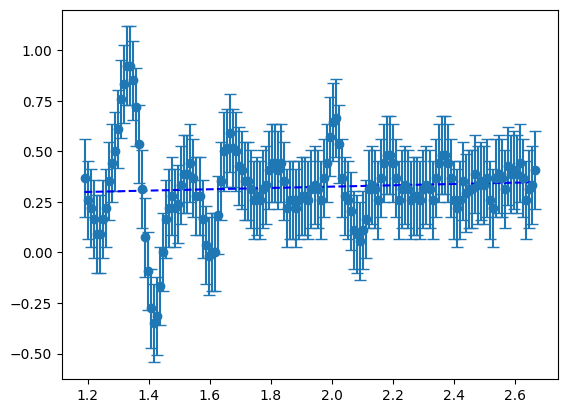

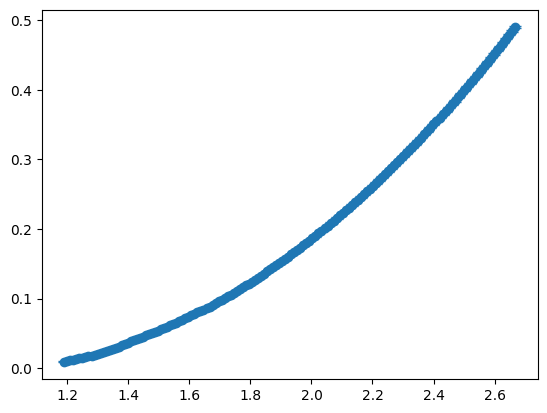

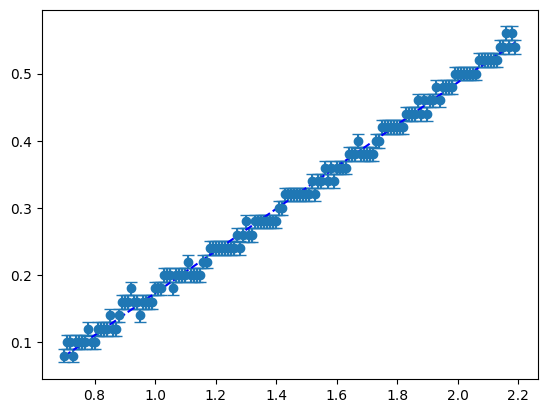

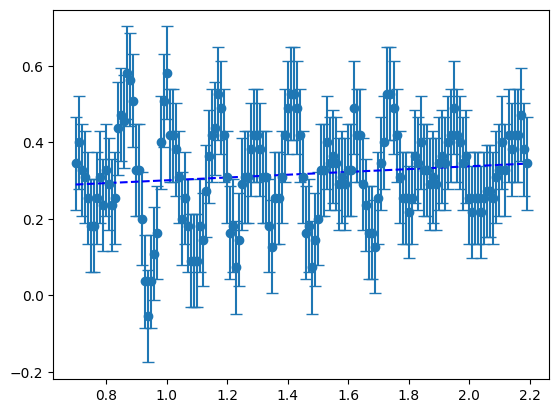

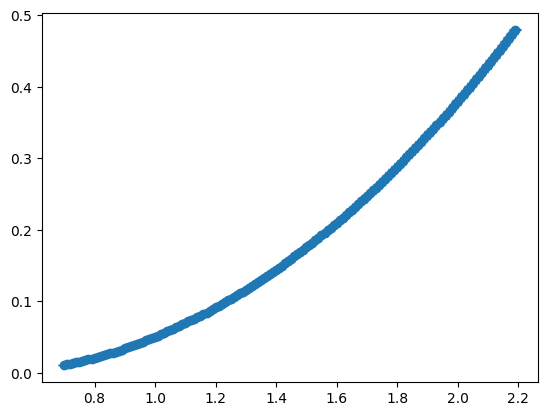

In [347]:
def get_errors_for_one_measurement(t, x, v, a):
    def plot_measurement_error(x, y, dy, f, *f_params_args):
        plt.figure()
        plt.errorbar(x,y,yerr=dy,fmt='o',capsize=4)
        t_values = np.linspace(t[0],t[-1],100)
        plt.plot(t_values,f(t_values, *f_params_args),'b--')
        plt.show()
    
    def f_linear(x,A,B):
        return A+B*x
        
    def f_parabolic(x,A,B,C):
        return A+B*x+C*x**2

    # calculate errors and plot them
    # v by t    
    param,cov = curve_fit(f_linear,t, v)
    A = param[0]
    B = param[1]
    dv = np.std(v-f_linear(t, A, B),ddof=2)
    plot_measurement_error(t, v, dv, f_linear, A, B)

    # a by t
    param,cov = curve_fit(f_linear,t, a)
    A = param[0]
    B = param[1]
    da = np.std(a-f_linear(t, A, B),ddof=2)
    plot_measurement_error(t, a, da, f_linear, A, B)

    # x by t
    param,cov = curve_fit(f_parabolic,t, x)
    A = param[0]
    B = param[1]
    C = param[2]
    dx = np.std(x-f_parabolic(t, A, B, C),ddof=3)
    plot_measurement_error(t, x, dx, f_parabolic, A, B, C)


    return dv, da,dx


#dv, da, dx = get_errors_for_one_measurement(t, x, v, a)
dv = [] 
da = []
dx = []
for i in range(len(t)):
    dv_i, da_i, dx_i = get_errors_for_one_measurement(t[i], x[i], v[i], a[i])
    dv.append(dv_i)
    da.append(da_i)
    dx.append(dx_i)

In [352]:
def create_intervals_for_one_measurement(t, x, v, a):
    total_points = len(t)
    points_per_interval = total_points // number_of_intervals_per_measurement
    # Create n separate intervals
    t_intervals = [t[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)]
    x_intervals = [x[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)]
    v_intervals = [v[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)]
    a_intervals = [a[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals_per_measurement)] 
    return t_intervals, x_intervals, v_intervals, a_intervals


#t_intervals, x_intervals, v_intervals, a_intervals = create_intervals_for_one_measurement(t, x, v, a)
# intarvals from MANY measurements
t_intervals = []
x_intervals = []
v_intervals = []
a_intervals = []
for i in range(len(t)):
    t_intervals_i, x_intervals_i, v_intervals_i, a_intervals_i = create_intervals_for_one_measurement(t[i], x[i], v[i], a[i])
    t_intervals.extend(t_intervals_i)
    x_intervals.extend(x_intervals_i)
    v_intervals.extend(v_intervals_i)
    a_intervals.extend(a_intervals_i)

In [353]:


"""
This function takes data arrays and processes them into data groups which are plotted as individual points.
"""
def group_measurements_into_points():
    def calculate_pi_1(x, v, t):
        return (x[-1]-x[0]) / (v[0] * (t[-1]-t[0]))

    def calculate_pi_2(a_mean, v, t):
        return a_mean * (t[-1]-t[0]) / v[0]

    pi_1 = []
    pi_1_errors = []
    pi_2 = []
    pi_2_errors = []
    for measurement_no in range(len(t)):
        for i in range(number_of_intervals_per_measurement):
            interval_index = measurement_no * number_of_intervals_per_measurement + i
            t_interval = t_intervals[interval_index]
            x_interval = x_intervals[interval_index]
            v_interval = v_intervals[interval_index]

            t_initial_error = unc.ufloat(t_interval[0], 0)
            t_final_error = unc.ufloat(t_interval[-1], 0)
            x_initial_error = unc.ufloat(x_interval[0], dx[])
            x_final_error = unc.ufloat(x_interval[-1], dx)
            v_initial_error = unc.ufloat(v_interval[0], dv)
            x_interval_with_error = [x_initial_error, x_final_error]
            t_interval_with_error = [t_initial_error, t_final_error]
            v_interval_with_error = [v_initial_error]

            pi1 = calculate_pi_1(x_interval_with_error, v_interval_with_error, t_interval_with_error)
            pi_1.append(pi1.nominal_value)
            pi_1_errors.append(pi1.std_dev)
            pi2 = calculate_pi_2(a_mean, v_interval_with_error, t_interval_with_error)
            pi_2.append(pi2.nominal_value)
            pi_2_errors.append(pi2.std_dev)
    
    return pi_1, pi_1_errors, pi_2, pi_2_errors

pi_1, pi_1_errors, pi_2, pi_2_errors = group_measurements_into_points()

def plot_regression_with_errors():
    def f(x,A,B):
        return A+B*x
    param,cov = curve_fit(f,pi_2,pi_1)
    A = unc.ufloat(param[0],np.sqrt(np.diag(cov))[0])
    B = unc.ufloat(param[1],np.sqrt(np.diag(cov))[1])
    print('A = {}'.format(A))
    print('B = {}'.format(B))

    plt.figure()
    pi2_values = np.linspace(min(pi_2),max(pi_2),100)
    plt.errorbar(pi_2,pi_1, xerr=pi_2_errors, yerr=pi_1_errors, fmt='o', capsize=4)
    plt.plot(pi2_values, f(pi2_values, *param),'b--')
    plt.show()

plot_regression_with_errors()

AttributeError: 'numpy.float64' object has no attribute 'strip'